# Milestone 2

This notebook aims to preprocess our data, and estimate the feasibility of the different ideas we had during the first milestone, using data exploration and some preliminary analysis.

- [Dataset description](#Dataset-description)
- [Initial dataset preprocessing](#Data-preprocessing)
    - [Characters dataset](#Characters-dataset) 
    - [Movies dataset](#Movies-dataset)
    - [Plot summaries dataset](#Plot-summaries-dataset)
- [External datasets](#External-datasets)
- [Data merging](#Data-merging)
- [Data exploration](#Data-exploration)

# Datasets description

This project utilizes a rich collection of datasets encompassing movies, characters, and plot summaries. The primary datasets include:

- **Characters Dataset** (`character.metadata.tsv`): Contains detailed metadata on movie characters and the actors portraying them. Key attributes include Wikipedia and Freebase IDs, movie release dates, character names, actor birthdates, genders, heights, ethnicities, and ages at the time of movie release.

- **Movies Dataset** (`movie.metadata.tsv`) Includes comprehensive information about movies. It features data such as Wikipedia and Freebase IDs, movie names, release dates, box office revenues, runtimes, languages, countries, and genres.

- **Plot Summaries Dataset** (`plot_summaries.text`): Offers a concise summary of movie plots, linked to movies through Wikipedia movie IDs.

### External datasets

We also use external datasets to enrich our data. More information about these datasets can be found in the [External datasets](#External-datasets) section.


# Initial dataset preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from src.utils.preprocessing_helpers import *

## Characters dataset

In [2]:
# Load the data
df_characters = pd.read_table('data/MovieSummaries/character.metadata.tsv', names=['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age_at_movie_release', 'freebase_actor_map_id', 'freebase_character_id', 'freebase_actor_id'])
df_characters.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


Let's check if we can find some missing values in the dataset.

In [3]:
df_characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   wikipedia_id                450669 non-null  int64  
 1   freebase_id                 450669 non-null  object 
 2   release_date                440674 non-null  object 
 3   character_name              192794 non-null  object 
 4   actor_dob                   344524 non-null  object 
 5   actor_gender                405060 non-null  object 
 6   actor_height                154824 non-null  float64
 7   actor_ethnicity             106058 non-null  object 
 8   actor_name                  449441 non-null  object 
 9   actor_age_at_movie_release  292556 non-null  float64
 10  freebase_actor_map_id       450669 non-null  object 
 11  freebase_character_id       192804 non-null  object 
 12  freebase_actor_id           449854 non-null  object 
dtypes: float64(2),

We can identify from the output above that:
- There are some *missing values*
- Some *type are not exploitable* (e.g. the `release_date` and `actor_dob`  are `object`s, not exploitable dates)

In [4]:
print(
    "Total amount of rows that contain a NaN value: ",
    df_characters.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": df_characters.isna().sum(),
        "nan_percentage": df_characters.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  405405


,nan_sum,nan_percentage
wikipedia_id,0,0.000000
freebase_id,0,0.000000
release_date,9995,2.217814
character_name,257875,57.220488
actor_dob,106145,23.552763
actor_gender,45609,10.120288
actor_height,295845,65.645740
actor_ethnicity,344611,76.466542
actor_name,1228,0.272484
actor_age_at_movie_release,158113,35.084064


Concerning the *missing values* problem, we have 3 options: not using the problematic features, dropping the rows or filling the missing values using external datasets.

Now we'll take a look at the values and see if we can find some outliers.

In [5]:
df_characters.describe(include='all')

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_actor_map_id,freebase_character_id,freebase_actor_id
count,4.506690e+05,450669,440674,192794,344524,405060,154824.000000,106058,449441,292556.000000,450669,192804,449854
unique,NaN,64330,18476,126629,29494,2,NaN,479,134078,NaN,450669,183435,135760
top,NaN,/m/0cc8620,2008,Doctor,1908-05-30,M,NaN,/m/0dryh9k,Mel Blanc,NaN,/m/0bgchxw,/m/0h577m2,/m/0c5vh
freq,NaN,115,5453,198,791,270257,NaN,16351,791,NaN,1,146,791
mean,1.396975e+07,NaN,NaN,NaN,NaN,NaN,1.788893,NaN,NaN,37.788523,NaN,NaN,NaN
std,1.079662e+07,NaN,NaN,NaN,NaN,NaN,4.379940,NaN,NaN,20.587870,NaN,NaN,NaN
min,3.300000e+02,NaN,NaN,NaN,NaN,NaN,0.610000,NaN,NaN,-7896.000000,NaN,NaN,NaN
25%,3.759292e+06,NaN,NaN,NaN,NaN,NaN,1.676400,NaN,NaN,28.000000,NaN,NaN,NaN
50%,1.189065e+07,NaN,NaN,NaN,NaN,NaN,1.750000,NaN,NaN,36.000000,NaN,NaN,NaN
75%,2.366501e+07,NaN,NaN,NaN,NaN,NaN,1.830000,NaN,NaN,47.000000,NaN,NaN,NaN


Uh, we can find a few interesting results:
- How can an actors' height be 510m ? 
- How can an actor's age be negative ?

### Release date and date of birth

To tackle the type problem we can convert the `object` type to `datetime` type.

In [6]:
df_characters['release_date_datetime'] = df_characters['release_date'].apply(convert_to_datetime)
df_characters['release_date_datetime'] = pd.to_datetime(df_characters['release_date_datetime'], errors='coerce')

print('Have lost %d release dates'%(df_characters['release_date_datetime'].isna().sum() - df_characters['release_date'].isna().sum()), 'now there are %d missing'%(df_characters['release_date_datetime'].isna().sum()))

df_characters['actor_dob_datetime'] = df_characters['actor_dob'].apply(convert_to_datetime)
df_characters['actor_dob_datetime'] = pd.to_datetime(df_characters['actor_dob_datetime'], errors='coerce')

print('Have lost %d actors dob'%(df_characters['actor_dob_datetime'].isna().sum() - df_characters['actor_dob'].isna().sum()), 'now there are %d missing'%(df_characters['actor_dob_datetime'].isna().sum()))

Have lost 15 release dates now there are 10010 missing
Have lost 34 actors dob now there are 106179 missing


### Height

In [7]:
df_characters[df_characters['actor_height'] > 2.5]

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_actor_map_id,freebase_character_id,freebase_actor_id,release_date_datetime,actor_dob_datetime
21619,1291587,/m/04qk12,2004-09-01,young Georgie,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,18.0,/m/0k276dx,/m/0k276dz,/m/0bggwvl,2004-09-01,1986-03-13
49659,30865068,/m/02ml14,1998-10-15,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0n9ld0y,NaN,/m/08hqh0,1998-10-15,1972-12-06
59719,12206655,/m/02vvw24,NaN,Dominic,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,NaN,/m/0k276dq,/m/0h8hcr1,/m/0bggwvl,NaT,1986-03-13
104140,17999628,/m/047n_2q,1998,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0cg31bd,NaN,/m/08hqh0,1998-01-01,1972-12-06
205679,1373475,/m/04xmx8,2003-08-15,Jackal Johnson,1972-12-06,M,510.0,NaN,Vince Corazza,30.0,/m/02vbm0k,/m/0h60xk7,/m/08hqh0,2003-08-15,1972-12-06
219383,179326,/m/018gq3,1996-11-18,Herbert,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,10.0,/m/0bggwv8,/m/0bggwvc,/m/0bggwvl,1996-11-18,1986-03-13
301653,4667507,/m/0cg9n6,2001-11-29,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,28.0,/m/0cg0zwp,NaN,/m/08hqh0,2001-11-29,1972-12-06
316621,3915041,/m/0b6lyp,2002,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,29.0,/m/02vc5p5,NaN,/m/08hqh0,2002-01-01,1972-12-06
341890,29290087,/m/0b3w9mr,1997-04-07,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,24.0,/m/0gvwy8x,NaN,/m/08hqh0,1997-04-07,1972-12-06
360967,14413223,/m/03d2rnl,2012-04-20,Young Punk Guy,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,26.0,/m/0m4q87d,/m/0k9tfs8,/m/0bggwvl,2012-04-20,1986-03-13


Using a few google searches, we found that for the 510.0m problem, the actor's height is 5'10" (1.78m). We'll have to fix this value.
Concerning the 180m problem, we can guess that the actor's height is 1.80m, but we can't find any source to confirm this (internet or other rows). We should drop these rows.

In [8]:
df_characters.drop(df_characters[df_characters['actor_height'] > 2.5].index, inplace=True)

### Age

Let's then take care of the age problem by removing the rows with negative age. 

In [9]:
print(df_characters.loc[(df_characters['actor_age_at_movie_release'] < 0)].shape[0], 'such rows will be removed')
df_characters = df_characters[df_characters['actor_age_at_movie_release'] > 0]

381 such rows will be removed


In [10]:
# Count the number of actor born after the movie release
df_characters[df_characters['actor_dob_datetime'] > df_characters['release_date_datetime']].shape[0]

0

### Check for duplicates

In [11]:
# Drop the rows that have duplicates
df_characters.drop_duplicates(subset=['freebase_id', 'freebase_actor_id', 'freebase_character_id'], inplace=True)

## Movie dataset

In [12]:
# For the movies metadata
df_movies = pd.read_table('data/MovieSummaries/movie.metadata.tsv', names=['wikipedia_id', 'freebase_id', 'name', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres'], header=None)

In [13]:
print(df_movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wikipedia_id  81741 non-null  int64  
 1   freebase_id   81741 non-null  object 
 2   name          81741 non-null  object 
 3   release_date  74839 non-null  object 
 4   revenue       8401 non-null   float64
 5   runtime       61291 non-null  float64
 6   languages     81741 non-null  object 
 7   countries     81741 non-null  object 
 8   genres        81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB
None


In [14]:
print(
    "Total amount of rows that contain a NaN value: ",
    df_movies.isna().any(axis=1).sum(),
)
pd.DataFrame(
    {
        "nan_sum": df_movies.isna().sum(),
        "nan_percentage": df_movies.isna().mean() * 100,
    }
)

Total amount of rows that contain a NaN value:  73498


,nan_sum,nan_percentage
wikipedia_id,0,0.000000
freebase_id,0,0.000000
name,0,0.000000
release_date,6902,8.443743
revenue,73340,89.722416
runtime,20450,25.018045
languages,0,0.000000
countries,0,0.000000
genres,0,0.000000


In [15]:
#Check for duplicate row
print('Check for duplicate entries:')
print(df_movies.duplicated().sum())

#Check for duplicated row with same name
print('Check for duplicate entries with name only:')
print(df_movies.duplicated(subset=['name']).sum())

#Check for duplicated row with same name and date release
print('Check for duplicate entries with name and date release:')
print(df_movies.duplicated(subset=['name', 'release_date']).sum())

#Check for duplicate row with same name and runtime
print('Check for duplicate entries with name and movie runtime:')
print(df_movies.duplicated(subset=['name', 'runtime']).sum())

#Check for duplicate row with same wikipedia ID
print('Check for duplicate entries with wikipedia ID:')
print(df_movies.duplicated(subset=['wikipedia_id']).sum())

Check for duplicate entries:
0
Check for duplicate entries with name only:
6263
Check for duplicate entries with name and date release:
103
Check for duplicate entries with name and movie runtime:
628
Check for duplicate entries with wikipedia ID:
0


We have some duplicate entries on the name but the wikipedia ID is always unique

In [16]:
df_movies.describe(include='all')

,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres
count,8.174100e+04,81741,81741,74839,8.401000e+03,6.129100e+04,81741,81741,81741
unique,NaN,81741,75478,20389,NaN,NaN,1817,2124,23817
top,NaN,/m/03vyhn,Alice in Wonderland,2006,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
freq,NaN,1,17,1011,NaN,NaN,33748,30300,6851
mean,1.740784e+07,NaN,NaN,NaN,4.799363e+07,1.118192e+02,NaN,NaN,NaN
std,1.098791e+07,NaN,NaN,NaN,1.121753e+08,4.360070e+03,NaN,NaN,NaN
min,3.300000e+02,NaN,NaN,NaN,1.000000e+04,0.000000e+00,NaN,NaN,NaN
25%,7.323695e+06,NaN,NaN,NaN,2.083193e+06,8.100000e+01,NaN,NaN,NaN
50%,1.777899e+07,NaN,NaN,NaN,1.063969e+07,9.300000e+01,NaN,NaN,NaN
75%,2.715573e+07,NaN,NaN,NaN,4.071696e+07,1.060000e+02,NaN,NaN,NaN


Looking at the output, we observe that:
- There a problem with the `release_date` column.
- The `runtime` column seems to have some outliers, with at least one movie with a runtime of 0, and one of 1 million minutes.

### Release date

We have a similar date problem as the one we had with the characters dataset. We'll fix it the same way.

In [17]:
# Convert the date strings to datetime objects
df_movies['release_date_datetime'] = df_movies['release_date'].apply(convert_to_datetime)
df_movies['release_date_datetime'] = pd.to_datetime(df_movies['release_date_datetime'], errors='coerce')

print('Have lost %d release dates'%(df_movies['release_date_datetime'].isna().sum() - df_movies['release_date'].isna().sum()), 'now there are %d missing'%(df_movies['release_date_datetime'].isna().sum()))

Have lost 1 release dates now there are 6903 missing


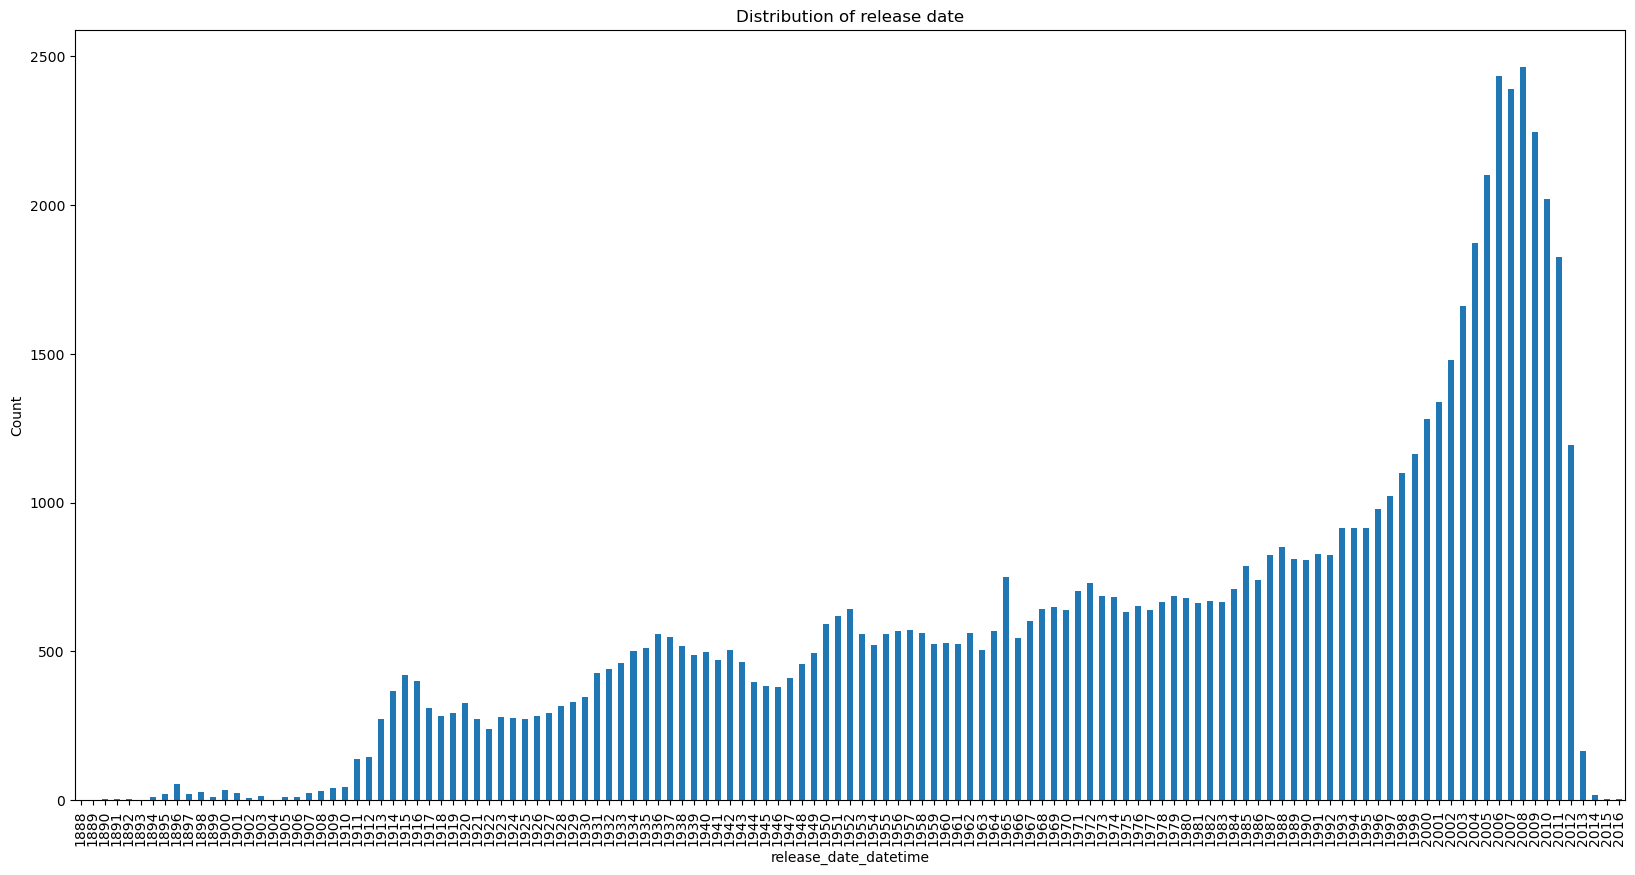

In [18]:
# Plot the distribution of the movie release date
plt.figure(figsize=(20, 10))
plt.title('Distribution of release date')
plt.xlabel('Release date')
plt.ylabel('Count')
df_movies.dropna(subset=['release_date_datetime'])['release_date_datetime'].dt.year.sort_values().value_counts(sort=False).plot(kind='bar')
plt.show()

In [19]:
print(f"There are {len(df_movies[df_movies['release_date_datetime'] >= pd.to_datetime('2014')])} movies are after 2014:")

There are 24 movies are after 2014:


### Runtime

We know that there are some outliers for `runtime`. We'll drop the rows with a `runtime` less or equal to 0 and greater than 500 minutes. 

In [20]:
old_shape = df_movies.shape[0]
df_movies.drop(df_movies[df_movies['runtime'] > 500].index, inplace=True)
df_movies.drop(df_movies[df_movies['runtime'] <= 0].index, inplace=True)
print(f"Have removed {old_shape - df_movies.shape[0]} rows")

Have removed 47 rows


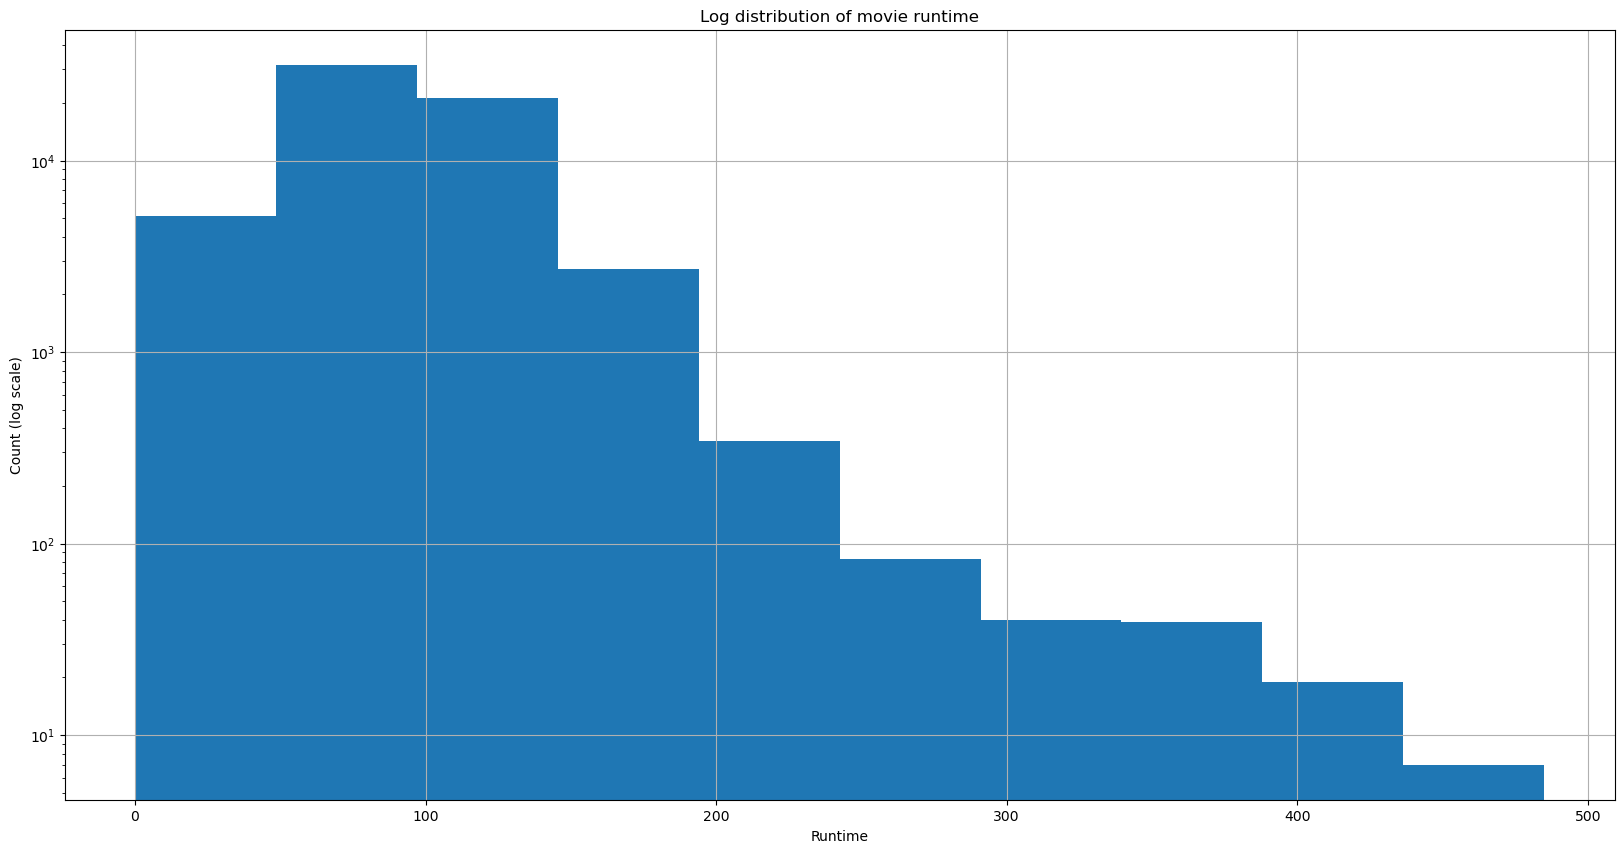

In [21]:
plt.figure(figsize=(20,10))
plt.title('Log distribution of movie runtime')
plt.xlabel('Runtime')
plt.ylabel('Count (log scale)')
plt.yscale('log')
df_movies.dropna(subset=['runtime'])['runtime'].hist(bins=10)
plt.show()

### Genres

The `genres` feature is represented by a dict, we'll explode this column to have a row for each genre.

In [22]:
# Extract the list of genres
df_movies['extracted_genres'] = df_movies.apply(lambda row: extract_list(row, 'genres'), axis=1)

# Explode the genres
df_movies_exploded = df_movies.explode('extracted_genres')

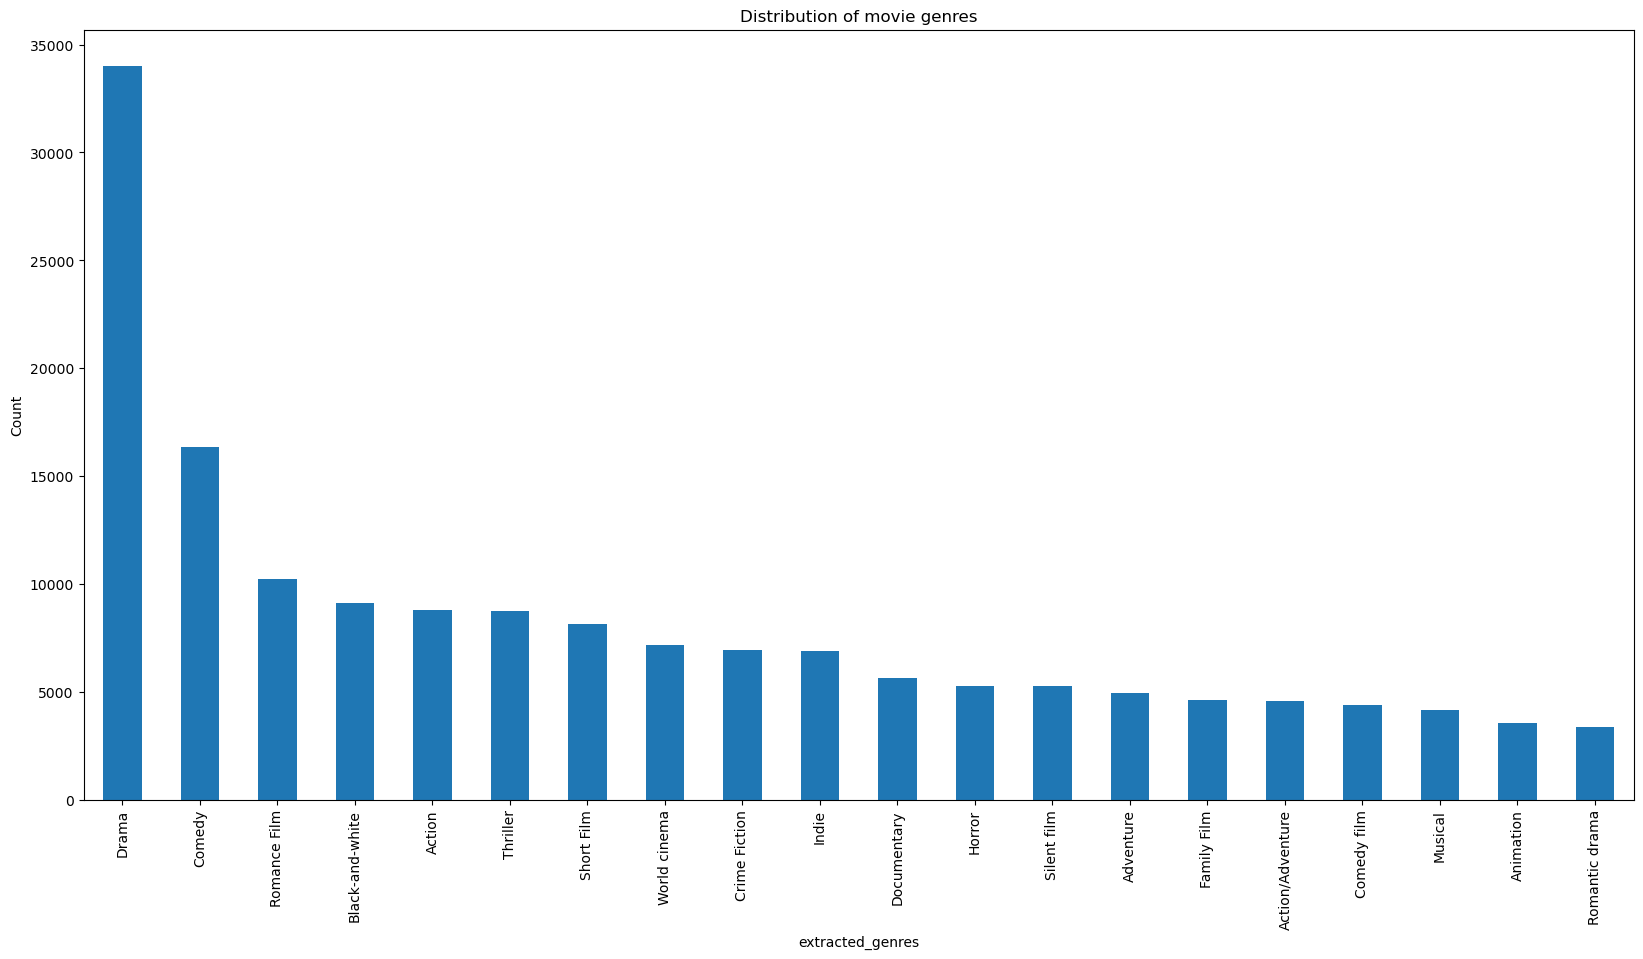

In [23]:
# Plot the distribution of movie genres, for the top 20 genres
plt.figure(figsize=(20,10))
plt.title('Distribution of movie genres')
plt.xlabel('Movie genres')
plt.ylabel('Count')
df_movies_exploded['extracted_genres'].value_counts().head(20).plot(kind='bar')
plt.show()

### Countries

Similarly to the `genres` column, the `countries` column is a dict of countries. We'll explode this column to have a row for each country.

In [24]:
# Extract the list of countries
df_movies['extracted_countries'] = df_movies.apply(lambda row: extract_list(row, 'countries'), axis=1)

# Explode the countries
df_movies_exploded = df_movies.explode('extracted_countries')

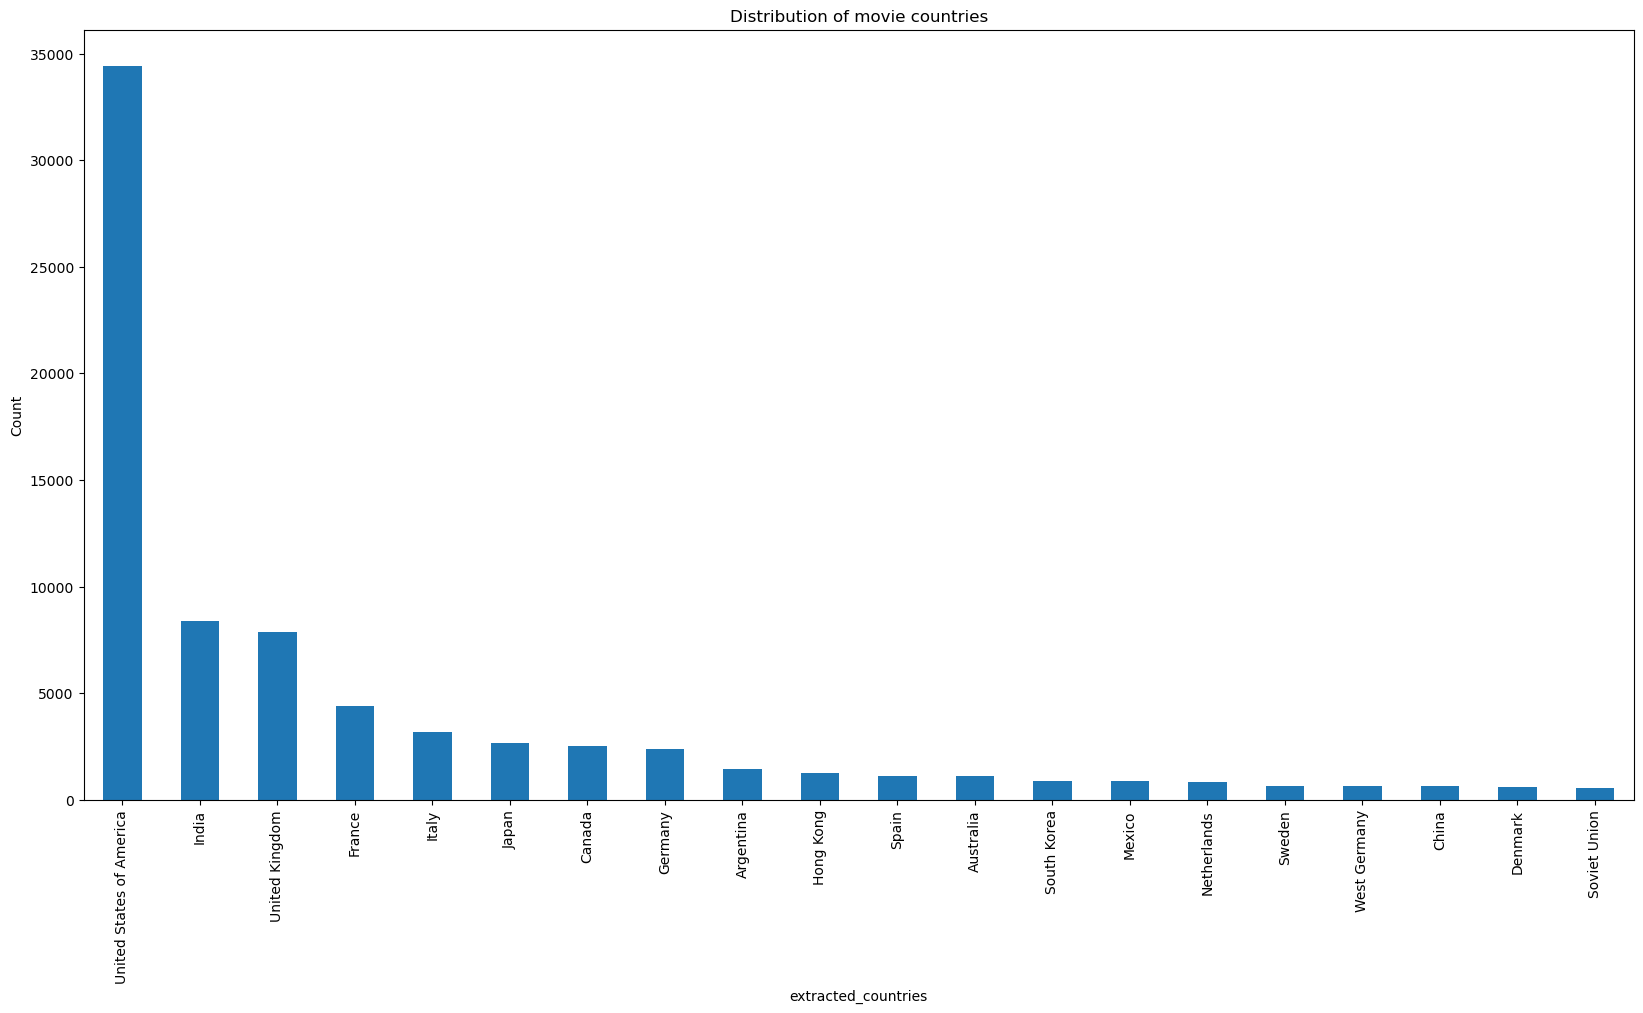

In [25]:
# Plot the distribution of movie countries, for the top 20 countries
plt.figure(figsize=(20,10))
plt.title('Distribution of movie countries')
plt.xlabel('Movie countries')
plt.ylabel('Count')
df_movies_exploded['extracted_countries'].value_counts().head(20).plot(kind='bar')
plt.show()

### Languages

Similarly to the `genres` column, the `languages` column is a dict of languages. We'll explode this column to have a row for each language.

In [26]:
# Extract the list of languages
df_movies['extracted_languages'] = df_movies.apply(lambda row: extract_list(row, 'languages'), axis=1)

# Explode the languages
df_movies_exploded = df_movies.explode('extracted_languages')

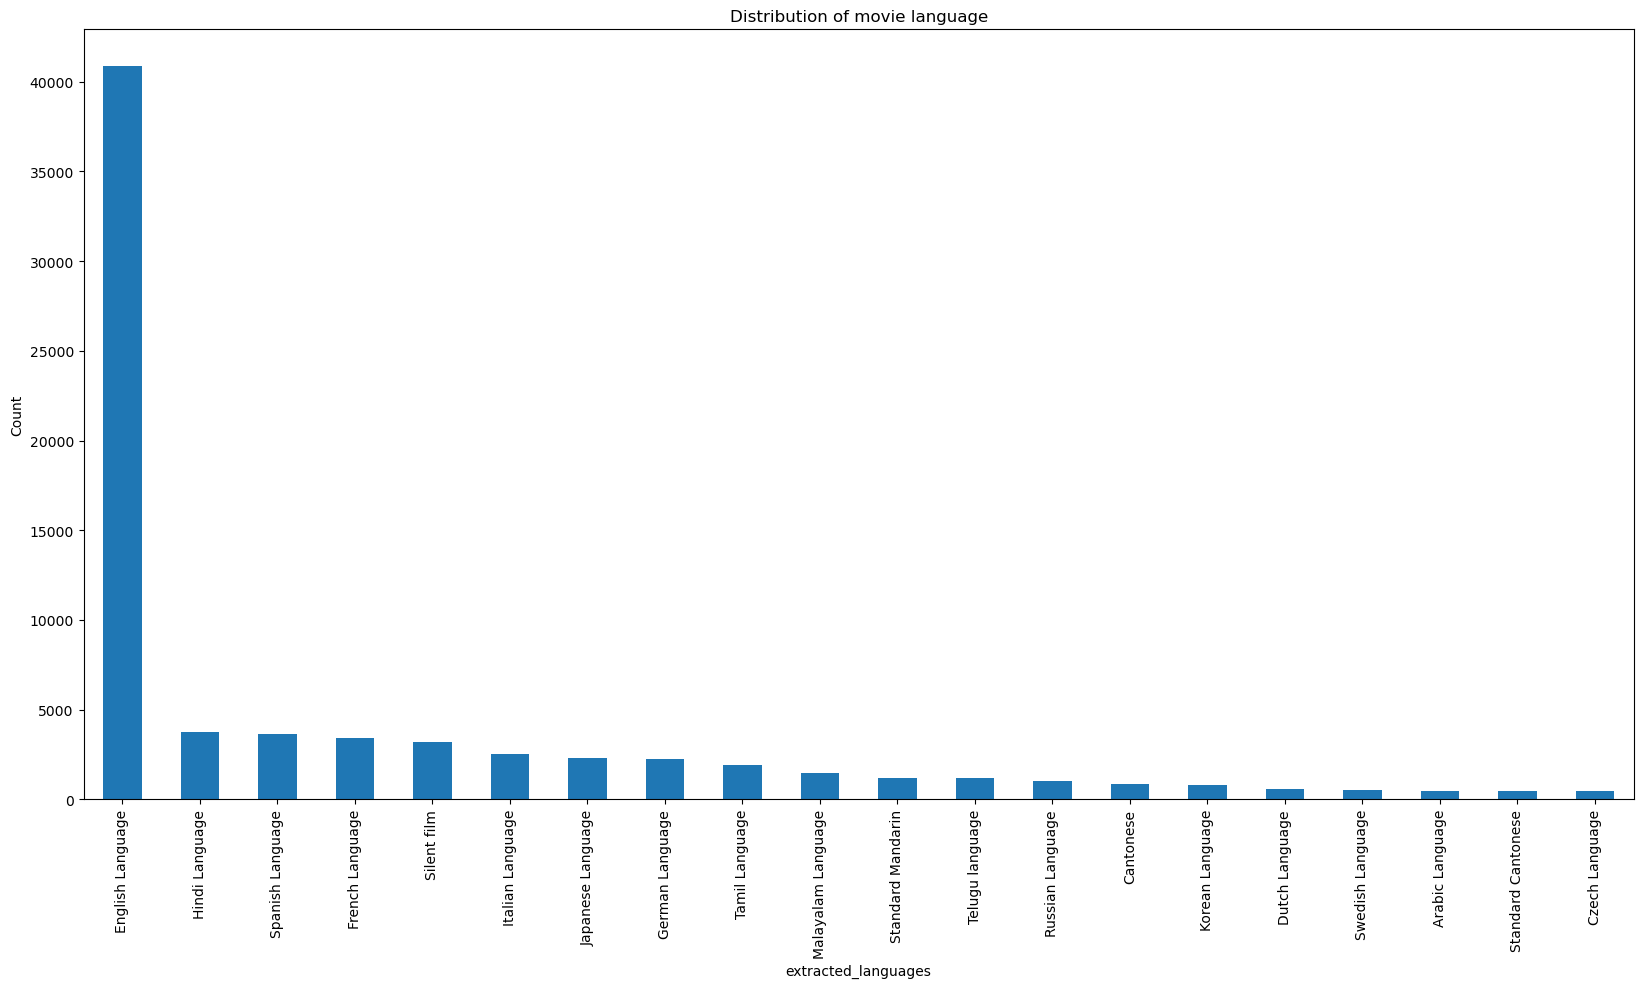

In [27]:
# Plot the distribution of movie language, for the top 20 languages
plt.figure(figsize=(20,10))
plt.title('Distribution of movie language')
plt.xlabel('Movie language')
plt.ylabel('Count')
df_movies_exploded['extracted_languages'].value_counts().head(20).plot(kind='bar')
plt.show()

## Plot summaries dataset

In [28]:
# For the plot summaries
df_plots = pd.read_table('data/MovieSummaries/plot_summaries.txt', names=['wikipedia_id', 'plot_summary'], header=None)

In [29]:
df_plots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   wikipedia_id  42303 non-null  int64 
 1   plot_summary  42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


In [30]:
print(f"There are {df_plots.duplicated(subset=['plot_summary']).sum()} duplicated plot summaries:")
df = pd.DataFrame(df_plots[df_plots.duplicated(subset=['plot_summary'])])
df

There are 8 duplicated plot summaries:


,wikipedia_id,plot_summary
14631,14055212,A woman is thrown out of her home by her jealo...
29428,14022275,A woman is thrown out of her home by her jealo...
30987,14051944,A woman is thrown out of her home by her jealo...
31702,14053389,A woman is thrown out of her home by her jealo...
35058,19609453,Raja was adopted by a criminal don at a very ...
38536,14616220,"As the American Civil War begins, Ned Burton l..."
38831,10791937,Taking a step aside from the usual serious dra...
39019,29481480,An orphan Raghav turns into a ruthless contrac...


There seems to be some movies with the same plot summary. 

In [31]:
df_movies[df_movies['wikipedia_id'].isin(df['wikipedia_id'])].sort_values(by=['wikipedia_id'])

,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,release_date_datetime,extracted_genres,extracted_countries,extracted_languages
59142,10791937,/m/02qq36m,Ninaithale Inikkum,1979-04-14,NaN,143.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""...",1979-04-14,"[Romantic drama, Romance Film, Drama, World ci...",[India],[Tamil Language]
18993,14022275,/m/03cr7rh,Madame X,1916-01-14,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",1916-01-14,"[Silent film, Drama, Indie, Black-and-white]",[United States of America],"[Silent film, English Language]"
57569,14051944,/m/03cs4lh,Madame X,1954,NaN,109.0,"{""/m/0349s"": ""Greek Language""}","{""/m/035qy"": ""Greece""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1954-01-01,"[Drama, Black-and-white]",[Greece],[Greek Language]
65014,14053389,/m/03cs5sb,Madame X,1981-03-16,NaN,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",1981-03-16,[Drama],[United States of America],[English Language]
4551,14055212,/m/03cs72m,The Trial of Madame X,1948,NaN,54.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1948-01-01,"[Drama, Black-and-white, Courtroom Drama]",[United Kingdom],[English Language]
15783,14616220,/m/03gqq2m,The Warrens of Virginia,1915-02-15,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",1915-02-15,"[Silent film, Drama, Indie, Black-and-white]",[United States of America],"[Silent film, English Language]"
22185,19609453,/m/05b2vs4,Amar Deep,1979,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",1979-01-01,"[Romance Film, Drama]",[India],[Hindi Language]
28621,29481480,/m/0ds08gq,Drohi,1992-10-25,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",1992-10-25,"[Thriller, Crime Fiction, Action, Drama]",[India],[Hindi Language]


# External Datasets

# Data merging